# Fraud Detection from Credit Card History, Machine learning algorithms
The following jupyter notebook contains a binary classification for fraud detection, from a credit card history. For this; we will explore the following three machine learning algorithms:
* Logistic Regression
* Decision Tree
* Linear Support Vector Machine
* Long Short Term Memory (LSTM)

This jupyter notebook would showcase the following:
1. Confusion matrix for each of the models
2. Cross validation metrics (precision, recall, f1_score, accuracy_score).
3. Plot of probability distributions between real test data vs each models predictions.

In [4]:
import sys
import os
import pandas as pd
import copy
import matplotlib.pyplot as plt

# Get the root project path
root_project_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Append it to sys
sys.path.append(root_project_path)

# Import the necessary modules
from utils import DataLoader, CreditCardPreprocesser

C:\Users\marqu\PycharmProjects\Argus\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the data

In [5]:
# Set the folder name and data folder
folder_name = "data"
data_holder_path = os.path.join(os.getcwd(), os.pardir)

# Set the folder name
data_loader = DataLoader(data_folder_name=folder_name,
    data_folder_path=data_holder_path)

# Get the data
df_data = data_loader.get_dataset()

### Get the preprocessed dataframe

In [6]:
# Create an instance of the Credit card processer
credit_card_processer = CreditCardPreprocesser(df_data=df_data)

# Obtain the df_preprocessed
df_preprocessed = credit_card_processer.fetch_preprocessed_dataframe()

In [4]:
# Print the shape
df_preprocessed.shape

(1296675, 96)

In [5]:
# Print the preprocessed dataframe
df_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 96 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   cc_num                   1296675 non-null  int64  
 1   amt                      1296675 non-null  float64
 2   gender                   1296675 non-null  int64  
 3   zip                      1296675 non-null  int64  
 4   lat                      1296675 non-null  float64
 5   long                     1296675 non-null  float64
 6   city_pop                 1296675 non-null  int64  
 7   unix_time                1296675 non-null  int64  
 8   merch_lat                1296675 non-null  float64
 9   merch_long               1296675 non-null  float64
 10  is_fraud                 1296675 non-null  int64  
 11  merch_zipcode            1296675 non-null  float64
 12  transaction_year         1296675 non-null  int32  
 13  transaction_month        1296675 non-null 

### Select the X and Y target

In [7]:
# Select the X and Y targets from the preprocessed data
X: pd.DataFrame = df_preprocessed[[col for col in df_preprocessed.columns if col != "is_fraud"]]
y: pd.DataFrame = df_preprocessed["is_fraud"]

In [7]:
# Display the Y value counts
y.value_counts()

is_fraud
0    1289169
1       7506
Name: count, dtype: int64

### Lets now oversample it using SMOTE

In [8]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()

# Obtain the over-sampled new values
X_smote, y_smote = smote.fit_resample(X.astype("float"), y)

In [7]:
# Display the y_smote value count
y_smote.value_counts()

is_fraud
0    1289169
1    1289169
Name: count, dtype: int64

### Select the continous columns:

We will select the continous columns; where we are going to apply our `Standardscaler()` instance from scikit-learn to perform standardscaling on ONLY the continous features.

In [9]:
# List all the continous features
continous_features = ["cc_num", "amt", "zip", "lat", "long", "city_pop", "unix_time",
    "merch_lat", "merch_long", "merch_zipcode", "transaction_year", "transaction_month",
    "transaction_day", "transaction_hour", "transaction_minute", "transaction_second",
    "birth_year", "birth_month", "birth_day", "merchant_encoded", "merchant_freq",
    "first_encoded", "first_freq", "last_encoded", "last_freq", "street_encoded",
    "street_freq", "city_encoded", "city_freq", "job_encoded", "job_freq"]

# Select the continous and not continous
X_smote_continous = X_smote[continous_features]
X_smote_discontinous = X_smote[[c for c in X_smote.columns if c not in continous_features]]

In [7]:
X_smote_discontinous.head(3)

,gender,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Implement the standardscaler to continous features

In [10]:
# Import standard scaler
from sklearn.preprocessing import StandardScaler

# Create a standard scaler object and fit x_train
standard_scaler = StandardScaler()
standard_scaler.fit(X_smote_continous)

# Transform x_train and x_test
X_continous_scaled = standard_scaler.transform(X_smote_continous)

In [11]:
# Create a pandas dataframe
X_continous_scaled = pd.DataFrame(X_continous_scaled,
    columns=X_smote_continous.columns)

In [12]:
X_continous_scaled.shape

(2578338, 31)

In [13]:
X_continous_scaled.head(3)

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,merch_zipcode,...,first_encoded,first_freq,last_encoded,last_freq,street_encoded,street_freq,city_encoded,city_freq,job_encoded,job_freq
0,-0.314146,-0.849665,-0.730733,-0.493568,0.635088,-0.285761,-1.755668,-0.502642,0.572527,-0.748980,...,-0.081514,1.395395,-0.301663,-0.634622,-0.348284,0.578598,-0.335459,0.201721,-0.255531,-0.059194
1,-0.316236,-0.553411,1.873809,2.008165,-2.005238,-0.296425,-1.755666,2.048246,-2.001306,-0.015091,...,-0.201122,0.425288,-0.227250,-0.472387,-0.348284,1.795535,-0.335459,1.620086,-0.243193,0.686028
2,-0.316207,-0.226389,1.286156,0.698217,-1.581124,-0.283660,-1.755666,0.882526,-1.571696,1.583852,...,-0.274487,-0.747764,-0.054028,0.176073,-0.348284,-1.273525,-0.335459,-1.224123,0.115153,-1.514150


### Create the actual datasets.

In [13]:
# These are the new datasets
X_data = pd.concat([X_continous_scaled, X_smote_discontinous], axis=1)
y_data = copy.copy(y_smote)

In [14]:
# Print the shapes
print(X_data.shape)
print(y_data.shape)

(2578338, 95)
(2578338,)


### Initialize the following classifiers
Now we will initialize each of the classifiers, and perform cross validation to obtain all the different metrics.

In [21]:
# Import libraries for the classifiers
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

In [22]:
# LSTM Model class
class LSTMModel:
    def __init__(self, input_shape, epochs=20, batch_size=64, learning_rate=0.001, patience=2):
        self.input_shape = input_shape
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.patience = patience

        # Use GPU if available, otherwise fallback to CPU
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Initialize the LSTM model
        self.model = LSTMNet(input_size=input_shape[1], hidden_size=32, output_size=1).to(self.device)
        self.criterion = nn.BCELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)

    def prepare_data(self, X, y):
        if isinstance(X, (pd.DataFrame, pd.Series)):
            X = X.to_numpy()
        if isinstance(y, (pd.DataFrame, pd.Series)):
            y = y.to_numpy()

        # Convert data to tensors (remain on CPU initially)
        X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(2)
        y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

        # Create DataLoader
        dataset = TensorDataset(X_tensor, y_tensor)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        return dataloader

    def fit(self, dataloader):
        for epoch in range(self.epochs):
            self.model.train()
            epoch_loss = 0
            for X_batch, y_batch in dataloader:
                # Move batch to GPU
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)

                # Zero gradients
                self.optimizer.zero_grad()

                # Forward pass
                outputs = self.model(X_batch).squeeze()
                loss = self.criterion(outputs, y_batch.squeeze())

                # Backward pass and optimization
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()

            # Print training loss for the epoch
            print(f"Epoch {epoch + 1}/{self.epochs}, Training Loss: {epoch_loss:.4f}")

            # Clear GPU memory after each epoch
            torch.cuda.empty_cache()

        return self


    def predict(self, X, batch_size=None):
        if isinstance(X, (pd.DataFrame, pd.Series)):
            X = X.to_numpy()

        # Convert data to tensor
        X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(2)  # Keep on CPU initially

        self.model.eval()  # Set the model to evaluation mode
        predictions = []

        with torch.no_grad():
            # Batch the data if batch_size is specified
            if batch_size is None:
                batch_size = self.batch_size

            for i in range(0, X_tensor.size(0), batch_size):
                # Process batch by batch
                batch = X_tensor[i:i + batch_size].to(self.device)
                batch_predictions = self.model(batch).squeeze().cpu().numpy()
                predictions.extend(batch_predictions)

        # Convert to binary predictions
        return (np.array(predictions) > 0.5).astype(int)



class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # LSTM forward pass
        lstm_out, _ = self.lstm(x)
        # Use the last hidden state for classification
        last_hidden = lstm_out[:, -1, :]
        output = self.fc(last_hidden)
        return self.sigmoid(output)


In [61]:
ml_classifiers = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Decision Tree Classifier": DecisionTreeClassifier(random_state=42),
    "Linear Support Vector Machine": LinearSVC(C=1.0, max_iter=1000),
    "LSTM Classifier": LSTMModel(input_shape=(X_data.shape[1], 1), epochs=20, batch_size=128, learning_rate=0.001)
}

### Split the data
We would like to perform the following:
1. Split our data into train_validation and test; we would hold the test dataset for a final analysis.
2. Perform cross validation using train_validation; and perform shuffled folds to see its accuracies.
3. Keep the saved cross val scores; for later analysis.

In [56]:
# Obtain the data into train_val and test
x_train_val, x_test, y_train_val, y_test = train_test_split(X_data, y_data,
    test_size=0.2, shuffle=True, random_state=42)
print(x_train_val.shape)
print(x_test.shape)
print(y_train_val.shape)
print(y_test.shape)

(2062670, 95)
(515668, 95)
(2062670,)
(515668,)


### Perform Cross validation for all ML algorithms
Perform cross validation for each of the ML algorithms, to obtain its results.

In [57]:
# Create the holders for each metrics
ml_metrics = {}

for name, clf in ml_classifiers.items():
    print(f"\n==========={name}============ Starting")
    # Initialize variables for each metric
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    # Perform 20 loops for all classifiers
    for i in range(20):
        print(f"Iteration: {i} - {name}")
        # Call the train-test split
        x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, shuffle=True)

        if name == "LSTM Classifier":
            # Prepare the DataLoader for training
            dataloader = clf.prepare_data(x_train, y_train)

            # Train the LSTM model
            clf.fit(dataloader)

            # Predict using batched prediction
            y_pred = clf.predict(x_val, batch_size=128)
        else:
            # Train and predict for other classifiers
            clf.fit(x_train, y_train)
            y_pred = clf.predict(x_val)

        # Calculate and append metrics
        accuracies.append(accuracy_score(y_val, y_pred))
        precisions.append(precision_score(y_val, y_pred))
        recalls.append(recall_score(y_val, y_pred))
        f1_scores.append(f1_score(y_val, y_pred))

    # Store metrics for the classifier
    ml_metrics[name + "_accuracies"] = accuracies
    ml_metrics[name + "_precisions"] = precisions
    ml_metrics[name + "_recalls"] = recalls
    ml_metrics[name + "_f1_scores"] = f1_scores

    # Save metrics to a CSV file
    df_results = pd.DataFrame(ml_metrics)
    df_results.to_csv(f'my_data_{name.replace(" ", "_")}.csv', index=False)
    print(f"\n==========={name}============ Ending")




===========Decision Tree Classifier============ Starting
Iteration: 0 - Decision Tree Classifier
Iteration: 1 - Decision Tree Classifier
Iteration: 2 - Decision Tree Classifier
Iteration: 3 - Decision Tree Classifier
Iteration: 4 - Decision Tree Classifier
Iteration: 5 - Decision Tree Classifier
Iteration: 6 - Decision Tree Classifier
Iteration: 7 - Decision Tree Classifier
Iteration: 8 - Decision Tree Classifier
Iteration: 9 - Decision Tree Classifier
Iteration: 10 - Decision Tree Classifier
Iteration: 11 - Decision Tree Classifier
Iteration: 12 - Decision Tree Classifier
Iteration: 13 - Decision Tree Classifier
Iteration: 14 - Decision Tree Classifier
Iteration: 15 - Decision Tree Classifier
Iteration: 16 - Decision Tree Classifier
Iteration: 17 - Decision Tree Classifier
Iteration: 18 - Decision Tree Classifier
Iteration: 19 - Decision Tree Classifier

===========Decision Tree Classifier============ Ending

===========Linear Support Vector Machine============ Starting
Iteration: 0 

# Data Visualization

Now that we have finally got the cross validation metrics, we will perform the last steps in order to see the different results of each of the ML models. This would be illustrated as:

1. Plot bar plot of accuracies, precision, recall, and f1 score for cross validation metrics of each of the models.

2. Next; after having the cross validation metrics; we previously have isolated a part of the data as test set. We are going to train a final model for each ML classifier, and obtain the test metrics as well. With these test and cross validation metrics; we are going to perform the following:
3. Plot bar plot of accuracies, precision, recall, and f1 score for test metrics of each of the models.
4. Generate confusion matrices for each of the test final models.
5. Create ROC curves for all models and overlay for comparison

In [62]:
from typing import List
import pandas as pd

def read_df_data(clfs_names: List[str]) -> pd.DataFrame:
    # Create a holder to store the data
    actual_data = {}

    for name in clfs_names:
        # Read the dataframe
        df_data = pd.read_csv("my_data_" + name.replace(" ", "_") + ".csv")

        # Assign it to the actual data properly
        actual_data[name + "_accuracies"] = df_data[name + "_accuracies"].to_numpy()
        actual_data[name + "_precisions"] = df_data[name + "_precisions"].to_numpy()
        actual_data[name + "_recalls"] = df_data[name + "_recalls"].to_numpy()
        actual_data[name + "_f1_scores"] = df_data[name + "_f1_scores"].to_numpy()

    # Convert the dictionary to a DataFrame and return
    return pd.DataFrame(actual_data)


In [69]:
# Get the cross validation metrics
df_cross_val_metrics = read_df_data(clfs_names=ml_classifiers.keys())

print(ml_classifiers.keys())


dict_keys(['Logistic Regression', 'Decision Tree Classifier', 'Linear Support Vector Machine', 'LSTM Classifier'])


In [70]:
df_cross_val_metrics.columns

Index(['Logistic Regression_accuracies', 'Logistic Regression_precisions',
       'Logistic Regression_recalls', 'Logistic Regression_f1_scores',
       'Decision Tree Classifier_accuracies',
       'Decision Tree Classifier_precisions',
       'Decision Tree Classifier_recalls',
       'Decision Tree Classifier_f1_scores',
       'Linear Support Vector Machine_accuracies',
       'Linear Support Vector Machine_precisions',
       'Linear Support Vector Machine_recalls',
       'Linear Support Vector Machine_f1_scores', 'LSTM Classifier_accuracies',
       'LSTM Classifier_precisions', 'LSTM Classifier_recalls',
       'LSTM Classifier_f1_scores'],
      dtype='object')

In [71]:
df_cross_val_metrics.head(2)

,Logistic Regression_accuracies,Logistic Regression_precisions,Logistic Regression_recalls,Logistic Regression_f1_scores,Decision Tree Classifier_accuracies,Decision Tree Classifier_precisions,Decision Tree Classifier_recalls,Decision Tree Classifier_f1_scores,Linear Support Vector Machine_accuracies,Linear Support Vector Machine_precisions,Linear Support Vector Machine_recalls,Linear Support Vector Machine_f1_scores,LSTM Classifier_accuracies,LSTM Classifier_precisions,LSTM Classifier_recalls,LSTM Classifier_f1_scores
0,0.899687,0.928379,0.866063,0.896139,0.998383,0.997545,0.999229,0.998386,0.885188,0.921258,0.842407,0.88007,0.985882,0.983947,0.987838,0.985889
1,0.900054,0.928668,0.866486,0.896500,0.998577,0.997847,0.999304,0.998575,0.886615,0.923331,0.843605,0.88167,0.983720,0.981556,0.985934,0.983740


### Plot the cross validation bar plots

In [74]:
# Create two lists for a new dataframe, models and metrics
models = ml_classifiers.keys()
metrics = ["accuracies", "precisions", "recalls", "f1_scores"]

# Conduct a df plot cross val
plot_cross_val = []
for model in models:
    model_data = [df_cross_val_metrics[f"{model}_{metric}"].mean() for metric in metrics]
    plot_cross_val.append(model_data)

# Convert to a Pandas DataFrame for plotting
df_plot_cross_val = pd.DataFrame(plot_cross_val, columns=metrics, index=models)

In [75]:
df_plot_cross_val.head(4)

,accuracies,precisions,recalls,f1_scores
Logistic Regression,0.899731,0.928143,0.866465,0.896244
Decision Tree Classifier,0.998446,0.997683,0.999211,0.998446
Linear Support Vector Machine,0.885423,0.920999,0.842967,0.880257
LSTM Classifier,0.820299,0.843698,0.798809,0.808898


### Plot the bar graph of cross val metrics

(0.7, 1.01)

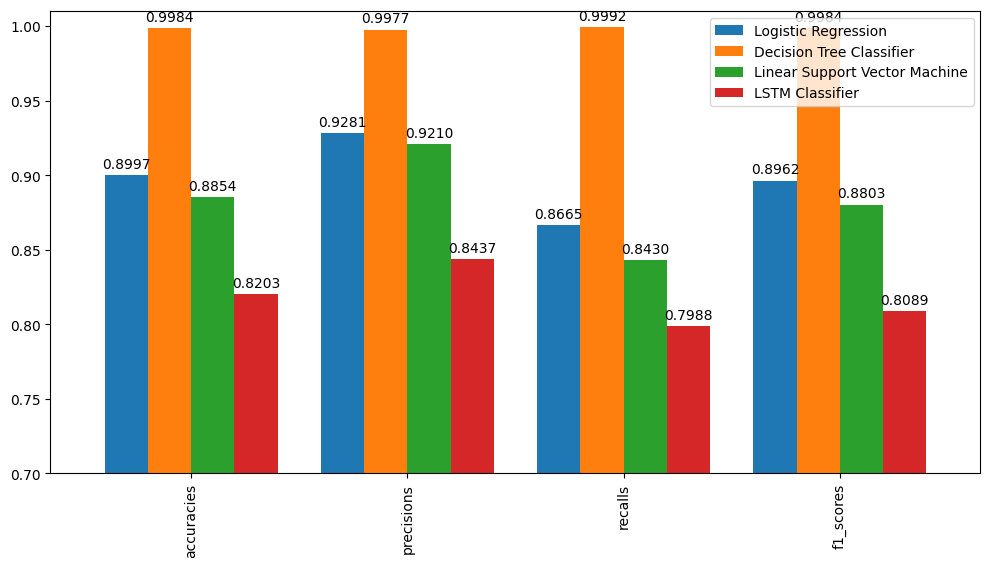

In [103]:
fig, axs = plt.subplots(1, figsize = (12, 6))
df_plot_cross_val.T.plot(ax=axs, kind="bar", legend=True, width = 0.8)

# Rotate x-axis ticks
axs.set_xticklabels(axs.get_xticklabels(), rotation=90, fontsize=10)

# Annotate bar values
for container in axs.containers:
    axs.bar_label(container, fmt='%.4f', fontsize=10, padding=3)

axs.set_ylim(0.70, 1.01)

### Train the final test models!
Even though its obvious the decision tree classifier is the best model between all the ML models; now we will perform the final test models and retrieve the metrics for each of them.

In [104]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score

# Create the holders for metrics
test_metrics = []
conf_matrices = []
class_reports = []
roc_auc_scores = []

for name, clf in ml_classifiers.items():
    print(f"\n==========={name}============ Starting")

    if name == "LSTM Classifier":
        # Prepare the DataLoader for LSTM
        dataloader = clf.prepare_data(x_train_val, y_train_val)

        # Train the LSTM model
        clf.fit(dataloader)

        # Use batched prediction to avoid memory issues
        y_pred = clf.predict(x_test, batch_size=128)
    else:
        # Train other classifiers
        clf.fit(x_train_val, y_train_val)
        y_pred = clf.predict(x_test)

    # Append metrics for the classifier
    test_metrics.append({
        "name": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1_score": f1_score(y_test, y_pred)
    })

    # Append confusion matrix directly as an array
    conf_matrices.append(confusion_matrix(y_test, y_pred))

    # Append classification report and ROC AUC score
    class_reports.append(classification_report(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, y_pred))

    print(f"\n==========={name}============ Ending")



===========Logistic Regression============ Starting
f1_score function: <function f1_score at 0x000002313F944940>

===========Logistic Regression============ Ending

===========Decision Tree Classifier============ Starting
f1_score function: <function f1_score at 0x000002313F944940>

===========Decision Tree Classifier============ Ending

===========Linear Support Vector Machine============ Starting
f1_score function: <function f1_score at 0x000002313F944940>

===========Linear Support Vector Machine============ Ending

===========LSTM Classifier============ Starting
Epoch 1/20, Training Loss: 11085.0871
Epoch 2/20, Training Loss: 11148.0607
Epoch 3/20, Training Loss: 10789.4511
Epoch 4/20, Training Loss: 11140.6440
Epoch 5/20, Training Loss: 9604.2960
Epoch 6/20, Training Loss: 9868.3108
Epoch 7/20, Training Loss: 10904.3046
Epoch 8/20, Training Loss: 10493.4133
Epoch 9/20, Training Loss: 9032.9358
Epoch 10/20, Training Loss: 10098.9402
Epoch 11/20, Training Loss: 9334.2176
Epoch 12/2

In [105]:
print(test_metrics)

[{'name': 'Logistic Regression', 'accuracy': 0.9001217837833645, 'precision': np.float64(0.9295361346770044), 'recall': np.float64(0.8664239676263724), 'f1_score': np.float64(0.8968711329678383)}, {'name': 'Decision Tree Classifier', 'accuracy': 0.9987414382897524, 'precision': np.float64(0.9981067411606063), 'recall': np.float64(0.9993848701263531), 'f1_score': np.float64(0.998745396727206)}, {'name': 'Linear Support Vector Machine', 'accuracy': 0.885759829968119, 'precision': np.float64(0.9224962105494915), 'recall': np.float64(0.842909757739417), 'f1_score': np.float64(0.8809090615043746)}, {'name': 'LSTM Classifier', 'accuracy': 0.9769910097194319, 'precision': np.float64(0.9729990985634553), 'recall': np.float64(0.981329454275346), 'f1_score': np.float64(0.9771465222843077)}]


In [106]:
import numpy as np

# Extract the numerical values from test_metrics
accuracy = [metric['accuracy'] for metric in test_metrics]
precision = [metric['precision'] for metric in test_metrics]
recall = [metric['recall'] for metric in test_metrics]
f1_score = [metric['f1_score'] for metric in test_metrics]

# Combine these into a NumPy array
np_test_metrics = np.array([accuracy, precision, recall, f1_score])

# Transpose to make each row represent a classifier
np_test_metrics = np_test_metrics.T

In [107]:
print("Metrics Array:")
print(np_test_metrics)

Metrics Array:
[[0.90012178 0.92953613 0.86642397 0.89687113]
 [0.99874144 0.99810674 0.99938487 0.9987454 ]
 [0.88575983 0.92249621 0.84290976 0.88090906]
 [0.97699101 0.9729991  0.98132945 0.97714652]]


In [108]:
# Create a dataframe of the model the test metrics
df_test_results = pd.DataFrame(np_test_metrics, columns=metrics, index=models)
print(df_test_results.head(4))

                               accuracies  precisions   recalls  f1_scores
Logistic Regression              0.900122    0.929536  0.866424   0.896871
Decision Tree Classifier         0.998741    0.998107  0.999385   0.998745
Linear Support Vector Machine    0.885760    0.922496  0.842910   0.880909
LSTM Classifier                  0.976991    0.972999  0.981329   0.977147


(0.1, 1.05)

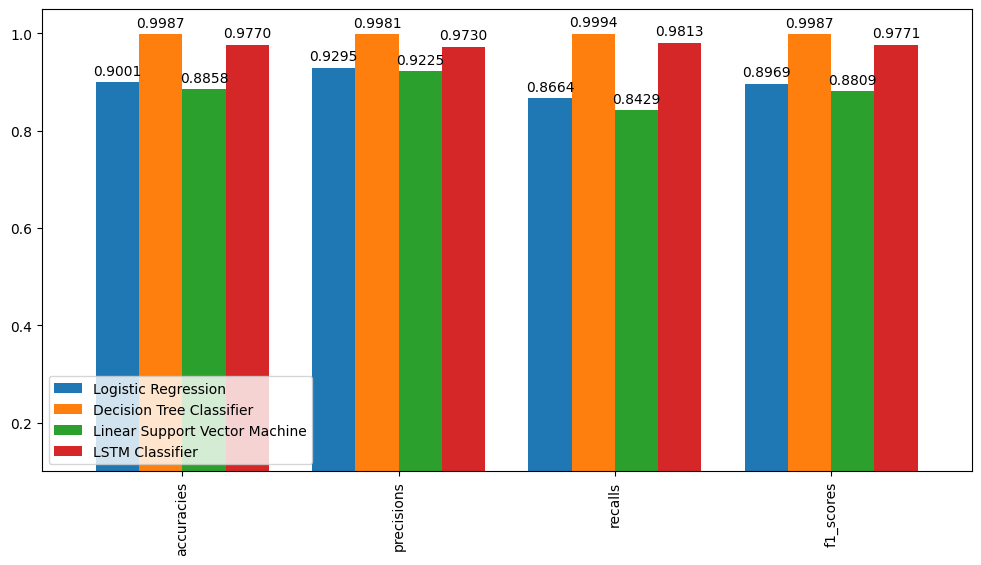

In [112]:
fig, axs = plt.subplots(1, figsize = (12, 6))
df_test_results.T.plot(ax=axs, kind="bar", legend=True, width = 0.8)

# Rotate x-axis ticks
axs.set_xticklabels(axs.get_xticklabels(), rotation=90, fontsize=10)

# Annotate bar values
for container in axs.containers:
    axs.bar_label(container, fmt='%.4f', fontsize=10, padding=3)

axs.set_ylim(0.10, 1.05)

### Print each of the classification reports

In [113]:
for i, name in enumerate(ml_classifiers):
    print(f"\n==========={name}============ class report")
    print(class_reports[i])


===========Logistic Regression============ class report
              precision    recall  f1-score   support

           0       0.87      0.93      0.90    257186
           1       0.93      0.87      0.90    258482

    accuracy                           0.90    515668
   macro avg       0.90      0.90      0.90    515668
weighted avg       0.90      0.90      0.90    515668


===========Decision Tree Classifier============ class report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257186
           1       1.00      1.00      1.00    258482

    accuracy                           1.00    515668
   macro avg       1.00      1.00      1.00    515668
weighted avg       1.00      1.00      1.00    515668


===========Linear Support Vector Machine============ class report
              precision    recall  f1-score   support

           0       0.85      0.93      0.89    257186
           1       0.92      0.84      0.88    2584

### Lets lot the confusion matrices now

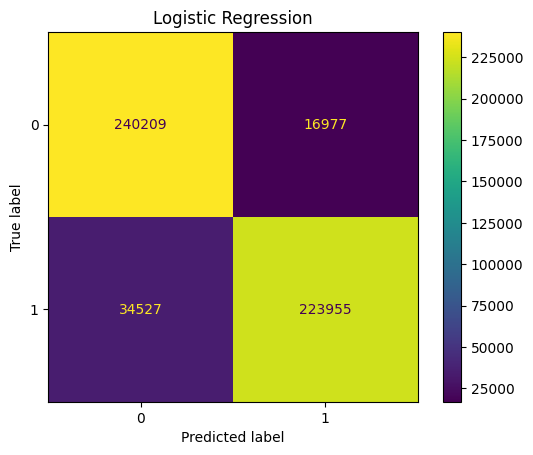

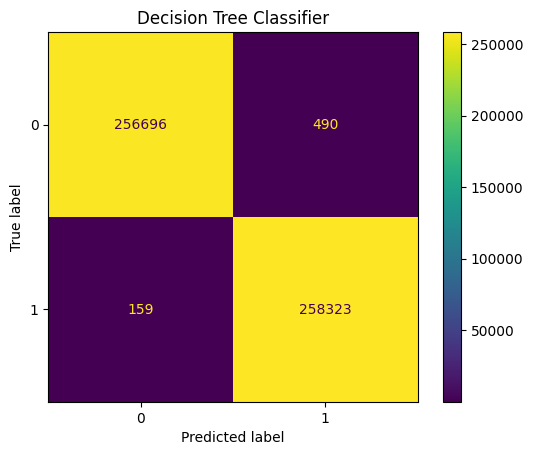

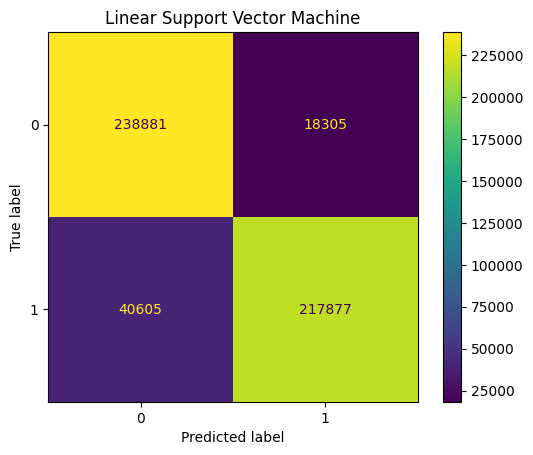

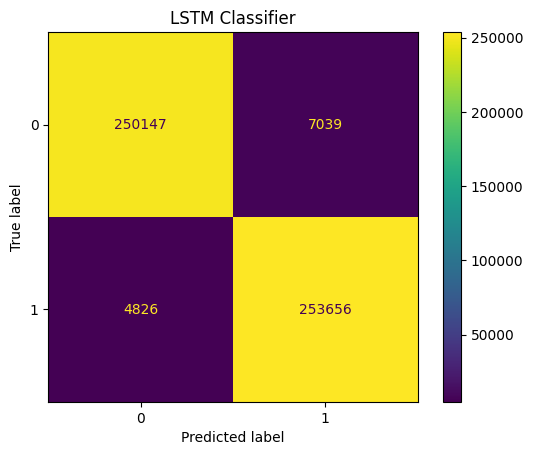

In [114]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Specify class labels (binary classification: [0, 1])
class_labels = [0, 1]

for i, name in enumerate(ml_classifiers.keys()):
    cm = conf_matrices[i]

    # Validate the matrix type
    if not isinstance(cm, (np.ndarray, list)):
        raise ValueError(f"Expected a confusion matrix array, got {type(cm)}")

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot()
    plt.title(name)
    plt.show()

### Finally, print the ROC auc scores

In [115]:
for i, name in enumerate(ml_classifiers):
    print(f"{name} ROC_AUC_Scores: {roc_auc_scores[i]}")

Logistic Regression ROC_AUC_Scores: 0.9002066880350336
Decision Tree Classifier ROC_AUC_Scores: 0.9987398171135214
Linear Support Vector Machine ROC_AUC_Scores: 0.885867794036164
LSTM Classifier ROC_AUC_Scores: 0.9769800786731376
